In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-10-27 16:59:40.899429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-27 16:59:42.040454: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-27 16:59:42.041248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-27 16:59:42.438825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-27 16:59:42.438865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-27 16:59:42.440742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2

In [3]:
stream = "gd1_tail"

In [4]:
df = load_file(stream = stream, percent_bkg = 25)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 0.154% of the dataset.


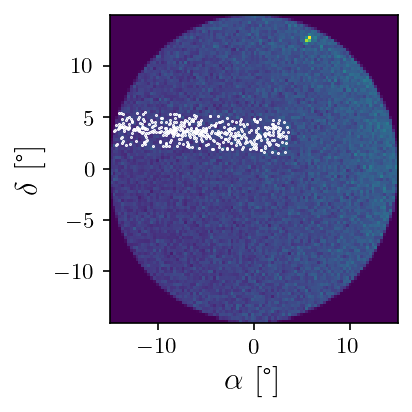

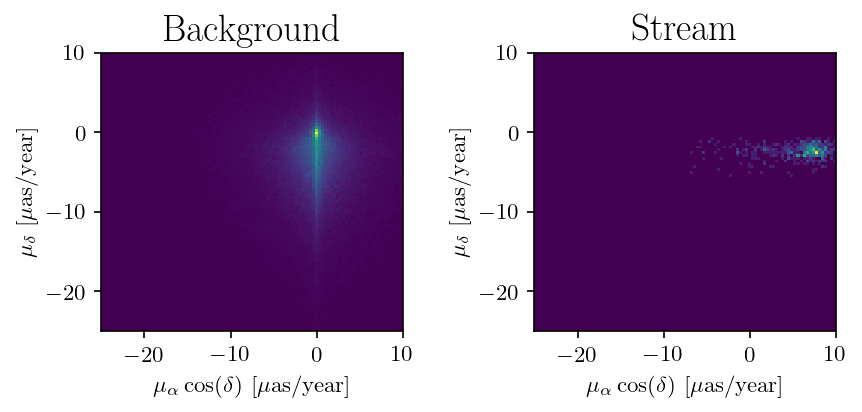

In [5]:
visualize_stream(df)

/home/mpettee/GaiaCWoLa/functions.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


Signal region has 355 stream and 69,989 bkg events.
Sideband region has 106 stream and 71,769 bkg events.
Total counts: SR = 70,344, SB = 71,875


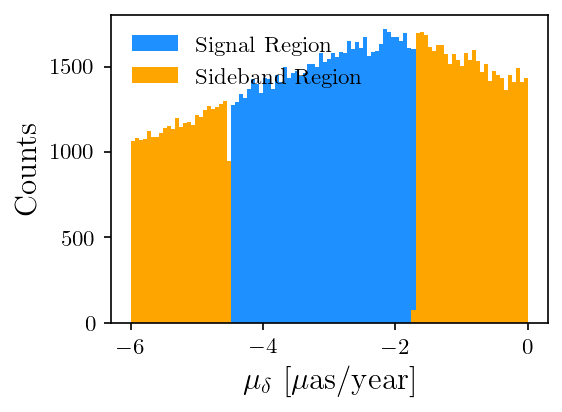

In [6]:
df_slice = signal_sideband(df, stream = stream)

In [10]:
### Prepare datasets for training
training_vars = ['μ_α','δ','α','color','mag']
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))]) # 70/15/15 train/validate/test split

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

print("Training on {:,} events.".format(len(train)))

Training on 99,553 events.


In [24]:
### Define model architecture 
layer_size = 64
dropout = 0.2
reg = regularizers.l2(1e-4)

model = Sequential()

model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
               activity_regularizer=reg
               )) 
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=30, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
checkpoint = callbacks.ModelCheckpoint("weights.h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                384       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

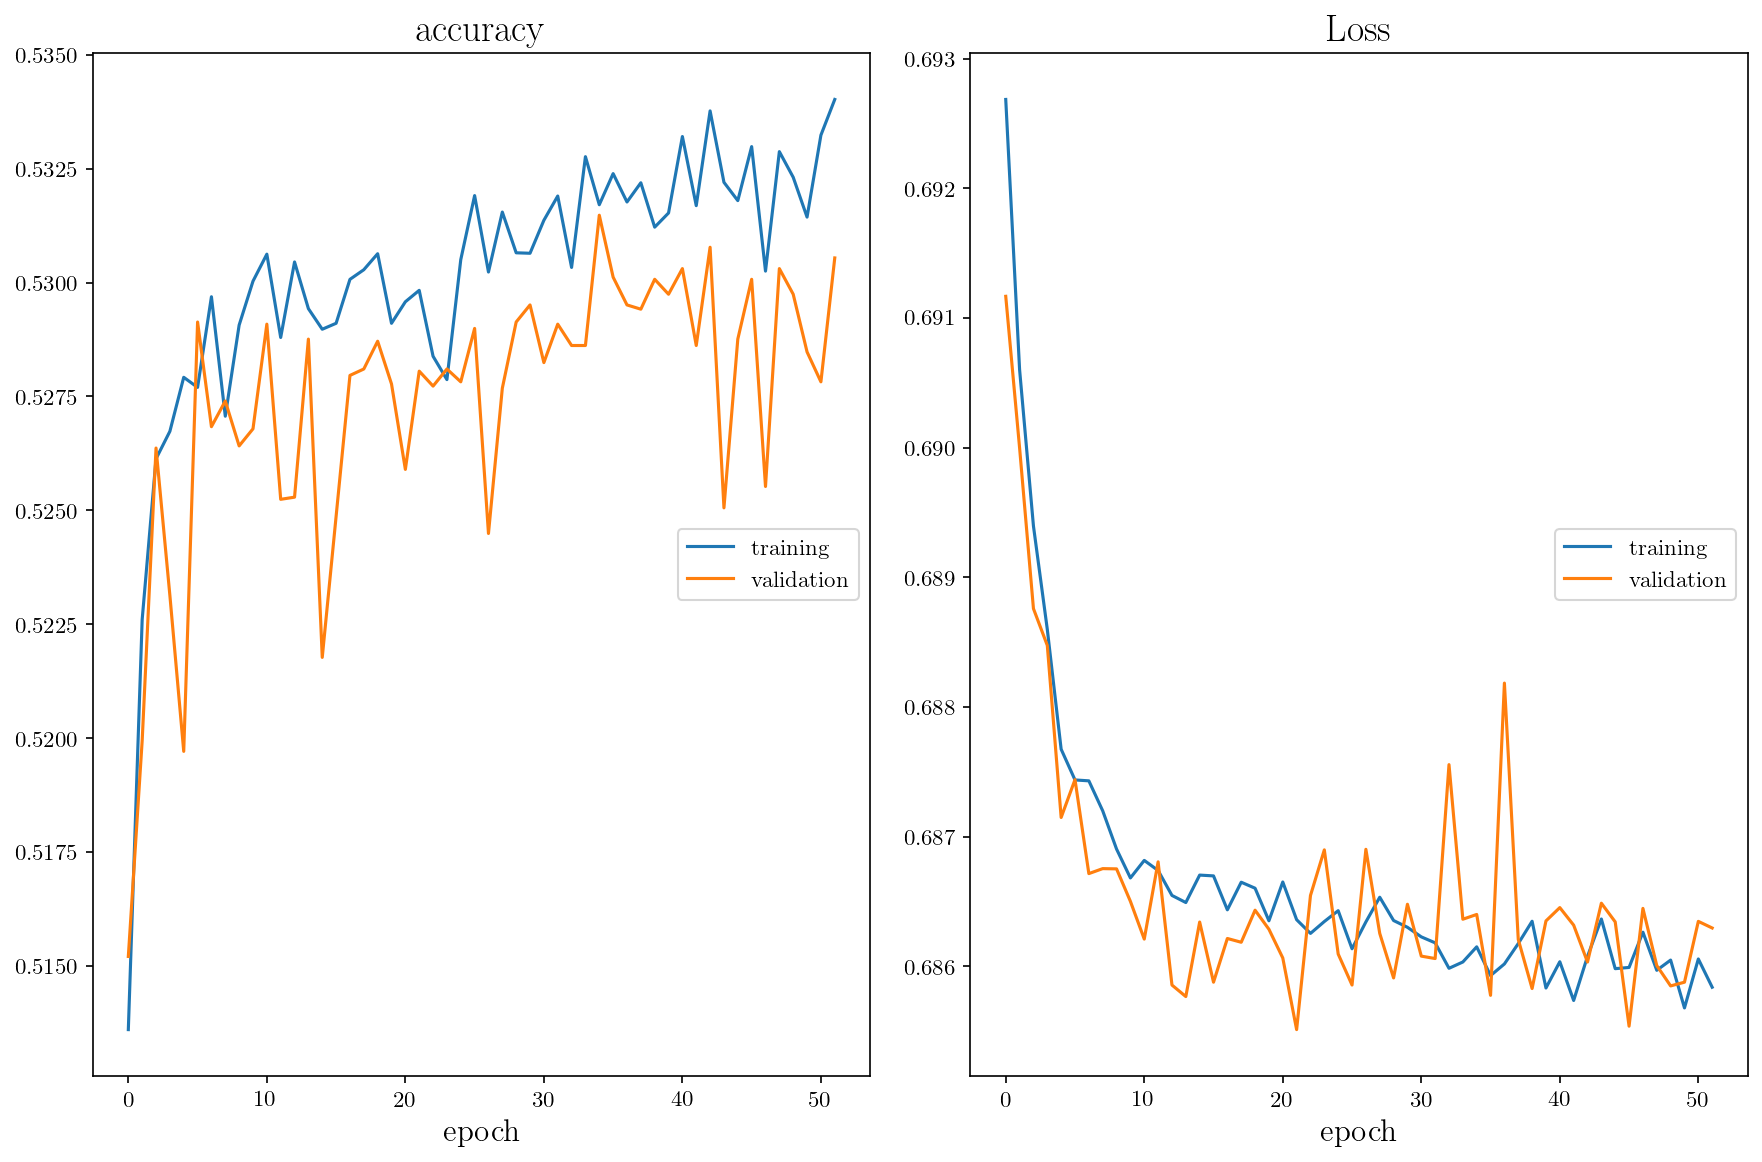

accuracy
	training         	 (min:    0.514, max:    0.534, cur:    0.534)
	validation       	 (min:    0.515, max:    0.531, cur:    0.531)
Loss
	training         	 (min:    0.686, max:    0.693, cur:    0.686)
	validation       	 (min:    0.686, max:    0.691, cur:    0.686)

Epoch 00052: val_loss did not improve from 0.68551
Epoch 00052: early stopping


In [25]:
### Train!
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesKeras(),checkpoint,early_stopping],
                    verbose = 2,
                   )

AUC: 0.550
Maximum purity of 33.3% at 0.01%
Cut at 0.001%...
Efficiency: 1.8%
Purity: 100.0%
Cut at 0.01%...
Efficiency: 1.8%
Purity: 33.3%
Cut at 0.1%...
Efficiency: 5.4%
Purity: 13.6%
Cut at 1%...
Efficiency: 16.1%
Purity: 4.2%
Cut at 5%...
Efficiency: 41.1%
Purity: 2.2%
Cut at 10%...
Efficiency: 75.0%
Purity: 2.0%
Cut at 20%...
Efficiency: 96.4%
Purity: 1.3%


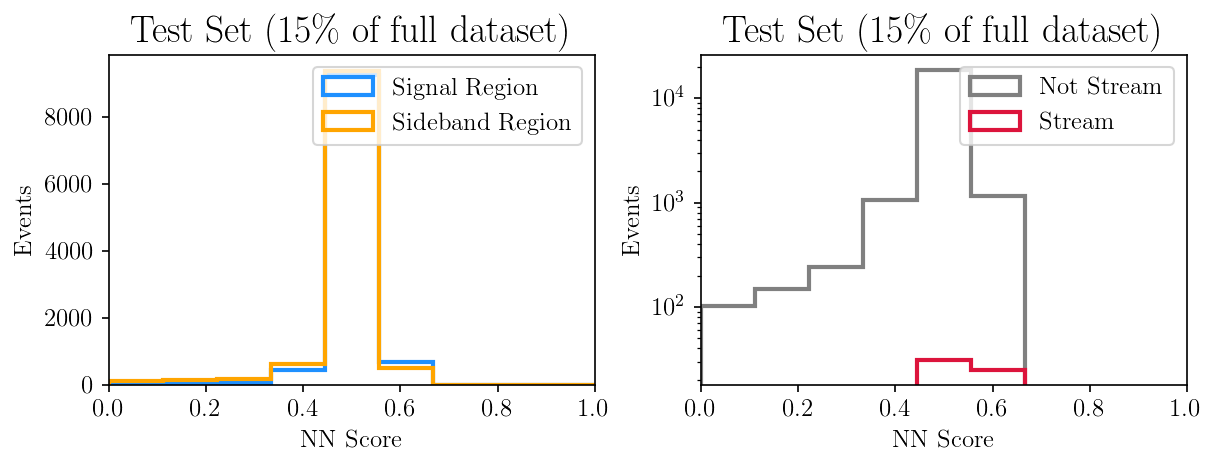

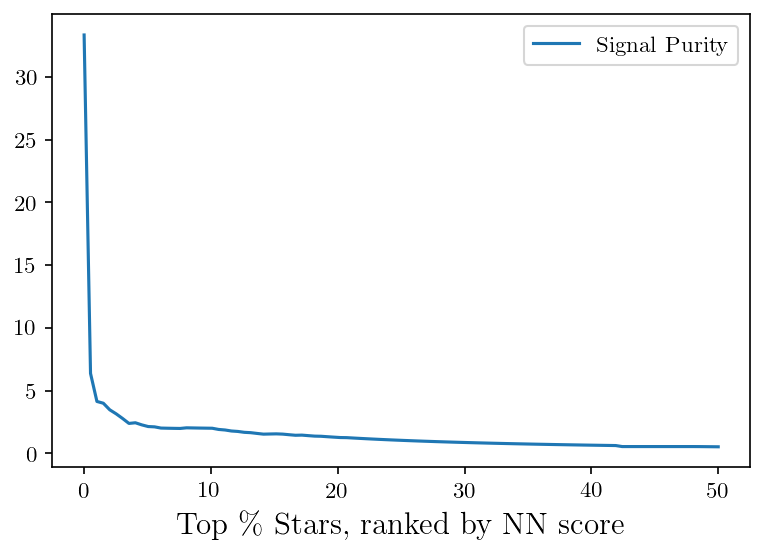

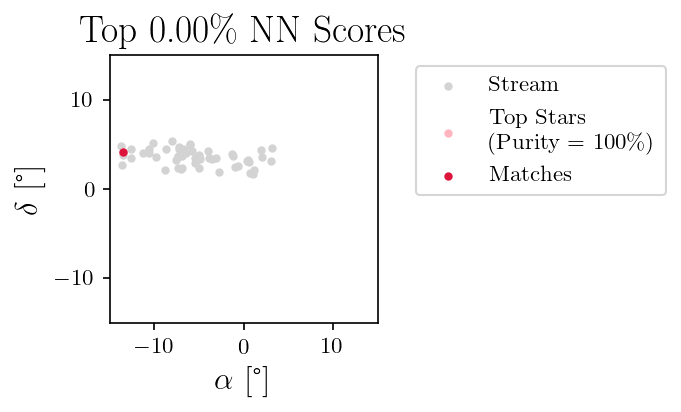

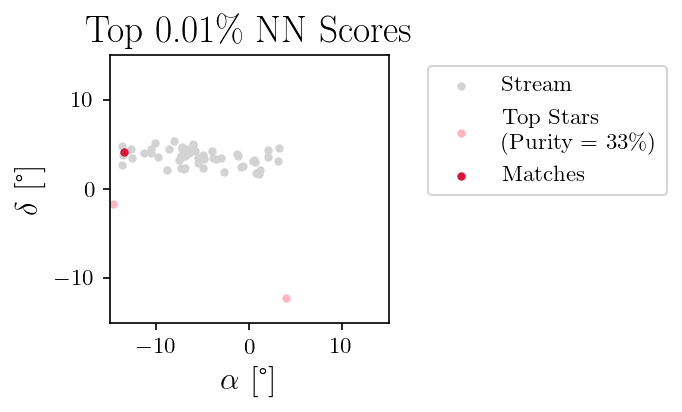

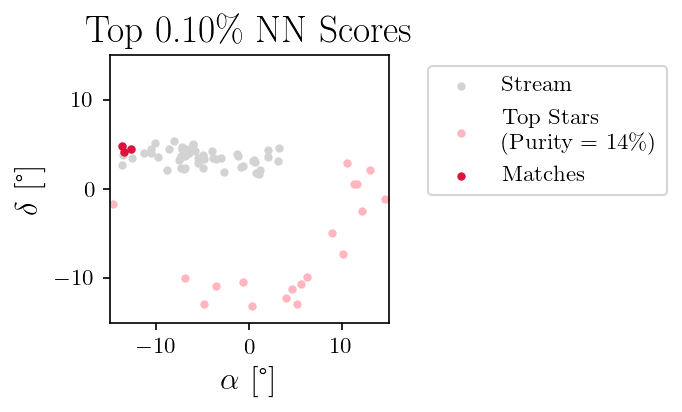

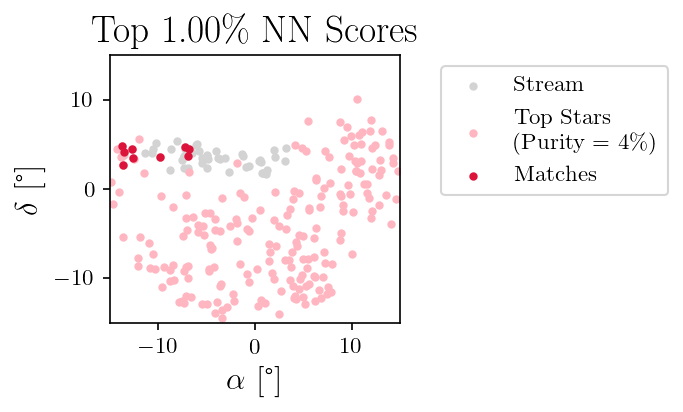

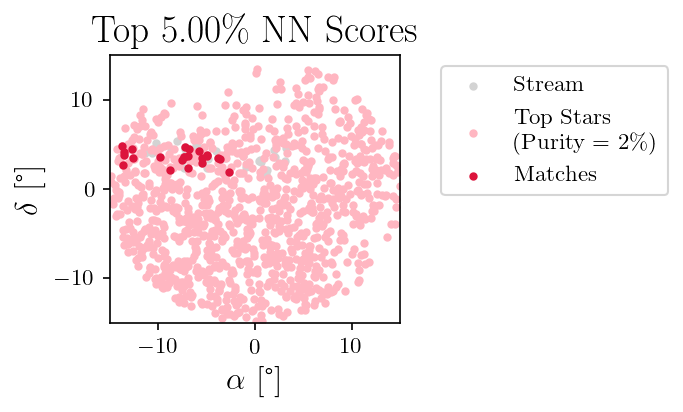

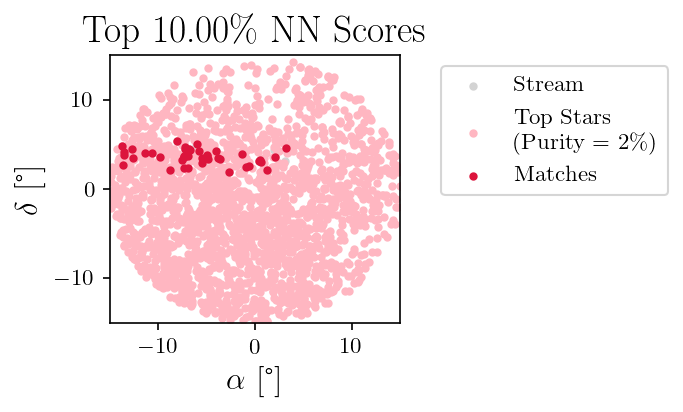

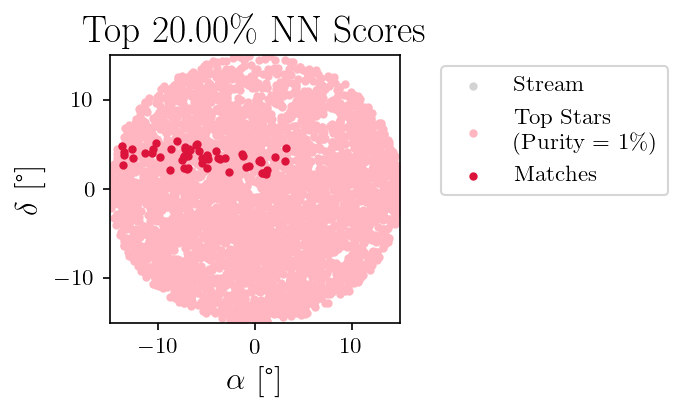

In [28]:
### Load best weights
model.load_weights("weights.h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {:.3f}".format(auc_baseline))

### Plot scores:
plot_results(test)